In [1]:
# Import libraries. 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [15]:
#Creating Color Palette for Different Populations

#for Oryx datasets:
custom_palette = {
    "EAD_A": "#cada45", #green
    "EAD_B": "#d4a2e1", #purple
    "EEP": "#55e0c6", #blue
    "USA": "#f0b13c", #orange
}

#for Galapagos Datasets:

In [24]:
#Loading the population data and covariance matrix

#load population data
population_names = pd.read_csv('input_files/oryx_pop_info_sorted_46_final.txt', sep='\t', header=0)
#load the covariance matrix
filename='input_files/oryx_2xyh_1K.cov'
cov_mat= pd.read_csv(filename, sep=' ', header=None)
#Generating the pandas dataframe called Data_Struct
Data_Struct=population_names

Optimal number of principal components): 5


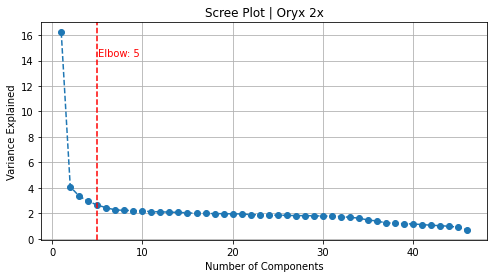

In [26]:
# Function to plot the scree plot
def plot_scree(explained_variance,filename_title,elbow_point):
    plt.figure(figsize=(8, 4))
    # Convert to a simple list if it's not already
    explained_variance = list(explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.axvline(x=elbow_point, color='r', linestyle='--')
    plt.text(elbow_point + 0.1, max(explained_variance) * 0.9, f'Elbow: {elbow_point}', color='red', verticalalignment='center')
    plt.title(f'Scree Plot | {filename_title}')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.grid()
    plt.show()

# Function to find the elbow point
def find_elbow_point(explained_variance, sensitivity=1.0):
    explained_variance = list(explained_variance)
    kneedle = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, 
                          curve='convex', direction='decreasing', 
                          S=sensitivity, interp_method='polynomial')
    return kneedle.elbow


#Calculate PCA
#convert covariance matrix to numpy array
cov_mat_np=cov_mat.to_numpy()

# calculate eigen vectors and eigen values from the initial covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
feature_vector = np.hstack([eigen_pairs[i][1][:, np.newaxis] for i in range(len(eigen_vals))])
principal_components = cov_mat_np.dot(feature_vector) 

# sorting them from largest to smallest
idx = eigen_vals.argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vecs[:,idx]

# calculating the total explained variance
expl_pre=eigenValues/sum(eigenValues)
expl=np.cumsum(expl_pre)

expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
expl_df['cumulative_expl']=expl*100
expl_df.set_index(np.arange(1, eigenVectors.shape[0] + 1), inplace=True)


# Plot the scree plot
plot_filename = f'scree_plot_{filename_title}.png'

 # Find the elbow point
elbow_point = find_elbow_point(expl_df['explained_variance'])
print("Optimal number of principal components):", elbow_point)

plot_scree(expl_df['explained_variance'],'Oryx 2x',elbow_point)

In [20]:
#define number of principal components to be used as inputs for UMAP and t-SNE calculations
n_pc = elbow_point
#define parameter range for t-SNE
perplexity_values=(5,10,23)
#define parameter space for UMAP
mindists=(0.01,0.1,0.5)
n_neighbors_nums=(5,10,23)

In [21]:
#t-SNE calculation
for perp in perplexity_values:
    np.random.seed(111)
    proj_tsne = TSNE(n_components=2,perplexity=perp).fit_transform(principal_components[:,:n_pc])
    Data_Struct['tSNE-1 perp'+str(perp)]=proj_tsne[:,0]
    Data_Struct['tSNE-2 perp'+str(perp)]=proj_tsne[:,1]

#UMAP calculation
for nn in n_neighbors_nums:
    for mind in mindists:
        np.random.seed(111)
        proj_umap = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=mind).fit_transform(principal_components[:,:n_pc])
        Data_Struct['UMAP-1 numn'+str(nn)+' mindist'+str(mind)]=proj_umap[:,0]
        Data_Struct['UMAP-2 numn'+str(nn)+' mindist'+str(mind)]=proj_umap[:,1]

/Users/kuzel/anaconda3/envs/beyondpca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kuzel/anaconda3/envs/beyondpca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/kuzel/anaconda3/envs/beyondpca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kuzel/anaconda3/envs/beyondpca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/kuzel/anaconda3/envs/beyondpca/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'ran

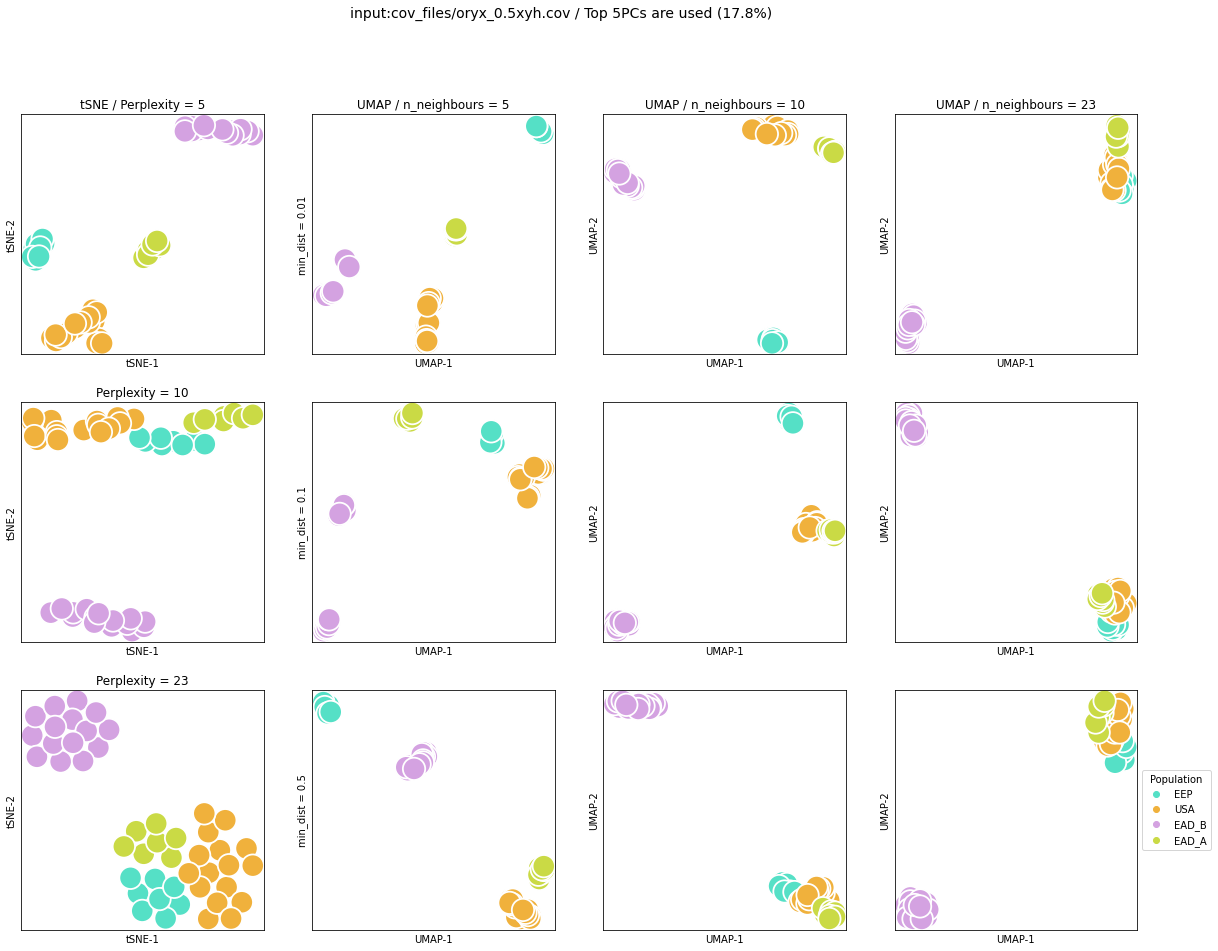

In [22]:

# Ensure the lengths of perplexity_values and mindists are equal
if len(perplexity_values) != len(mindists):
    raise ValueError("The number of perplexity values must be equal to the number of minimum distance values.")

# Determine the number of rows and columns for the subplot grid
n_rows = len(perplexity_values)
n_cols = 1 + len(n_neighbors_nums)  # Adding 1 for t-SNE and the rest for UMAP

# Create the subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle("input:" + filename + ' / Top ' + str(n_pc) + 'PCs are used (' + str(round(expl_df['cumulative_expl'][n_pc-1], 1)) + '%)', fontsize=14)

# t-SNE plots (first column)
for i, perp in enumerate(perplexity_values):
    sns.scatterplot(ax=axs[i, 0], data=Data_Struct, x='tSNE-1 perp' + str(perp), y='tSNE-2 perp' + str(perp), s=500, hue='Population', palette=custom_palette, legend=False)
    axs[i, 0].set_xlabel('tSNE-1')
    axs[i, 0].set_ylabel('tSNE-2')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    # Set the title differently for the first plot
    if i == 0:
        axs[i, 0].set_title('tSNE / Perplexity = ' + str(perp))
    else:
        axs[i, 0].set_title('Perplexity = ' + str(perp))


# UMAP plots (next columns)
for j, nn in enumerate(n_neighbors_nums):
    for i, mind in enumerate(mindists):
        is_last_plot = (i == len(mindists) - 1) and (j == len(n_neighbors_nums) - 1)
        sns.scatterplot(ax=axs[i, j + 1], data=Data_Struct, x='UMAP-1 numn' + str(nn) + ' mindist' + str(mind), y='UMAP-2 numn' + str(nn) + ' mindist' + str(mind), s=500, hue='Population', palette=custom_palette, legend=is_last_plot)
        
        if i == 0:
            axs[i, j + 1].set_title('UMAP / n_neighbours = ' + str(nn))
        axs[i, j + 1].set_xlabel('UMAP-1')

        # Set the y-axis label differently for the first column of UMAP plots
        if j == 0:
            axs[i, j + 1].set_ylabel('min_dist = ' + str(mind))
        else:
            axs[i, j + 1].set_ylabel('UMAP-2')

        axs[i, j + 1].set_xticks([])
        axs[i, j + 1].set_yticks([])
        
        # Adjust the legend for the last UMAP plot (bottom-right)
        if is_last_plot:
            axs[i, j + 1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Population')


# Save the figure
plt.savefig(filename[:-4] + '_Top' + str(n_pc) + 'PCs.png', format='png', dpi=100, transparent=False, facecolor='white')
